1. KDDCup
2. tramento [ 8 tipos ]
  * Limpeza de Dados
  * Normalização
  * Transformação de Variáveis Categóricas
  * Redução de Dimensionalidade
#2. Tratamento de Dados
  * Limpeza de Dados: Remoção de entradas duplicadas ou irrelevantes.
  * Normalização: Escalonamento dos dados para que todas as variáveis tenham a mesma importância. Isso pode ser feito usando técnicas como Min-Max Scaling ou Z-score normalization.
  * Transformação de Variáveis Categóricas: Conversão de variáveis categóricas em numéricas, utilizando técnicas como one-hot encoding.
  * Redução de Dimensionalidade: Aplicação de técnicas como PCA (Análise de Componentes Principais) para reduzir o número de características, mantendo a maior quantidade de informação possível.

In [ ]:
# importar bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
# pip install pandas numpy sklearn
#%pip install --upgrade scikit-learn xgboost

In [ ]:
# Caminho para o arquivo
caminho_arquivo = "./kddcup.data"

# Carregar o arquivo (sem cabeçalhos)
colunas = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
    "label"
]

# Carregar os dados com os nomes das colunas
dados = pd.read_csv(caminho_arquivo, header=None, names=colunas)

In [ ]:
dados.shape

(4898431, 42)

In [ ]:
#1. Limpeza de Dados (Remoção de Entradas Duplicadas ou Irrelevantes)
# Remover entradas duplicadas
dados_with_out_duplicates = dados.drop_duplicates()
# Remover linhas com valores nulos
dados_with_out_empty_values = dados_with_out_duplicates.dropna()
dados_with_out_empty_values.reset_index(drop=True, inplace=True)

In [ ]:
dados_with_out_empty_values.shape

(1074992, 42)

In [ ]:
# Separar os dados numéricos e categóricos
dados_numericos = dados_with_out_empty_values.select_dtypes(include=["int64", "float64"])
dados_categoricos = dados_with_out_empty_values.select_dtypes(include=["object"])

In [ ]:
# 2. Codificar dados categóricos
# Usar OneHotEncoding para colunas categóricas
one_hot_encoder = OneHotEncoder(sparse_output=False)
dados_categoricos_one_hot = pd.DataFrame(
    one_hot_encoder.fit_transform(dados_categoricos.drop(columns=["label"])),
    columns=one_hot_encoder.get_feature_names_out(dados_categoricos.columns[:-1])
)

In [ ]:
# 3. Normalizar dados numéricos
scaler = MinMaxScaler()
dados_numericos_normalizados = pd.DataFrame(scaler.fit_transform(dados_numericos), columns=dados_numericos.columns)

In [ ]:
#Combinar tudo
dados_normalizados = pd.concat([dados_numericos_normalizados, dados_categoricos_one_hot, dados_categoricos["label"]], axis=1)

In [ ]:
# Resetar os índices antes de concatenar
dados_numericos_normalizados.reset_index(drop=True, inplace=True)
dados_categoricos_one_hot.reset_index(drop=True, inplace=True)
dados_categoricos["label"].reset_index(drop=True, inplace=True)

In [ ]:
try:
    # IQR method to remove outliers
    for col in dados_normalizados.select_dtypes(include=['number']).columns:  # Apply only to numerical columns
        Q1 = dados_normalizados[col].quantile(0.25)
        Q3 = dados_normalizados[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        dados_normalizados = dados_normalizados[(dados_normalizados[col] >= lower_bound) & (dados_normalizados[col] <= upper_bound)]

    print("----------Dados do Head após remoção de outliers----------\n")
    print(dados_normalizados.head())

    print("\n\n ----------Dados do Info após remoção de outliers----------\n")
    print(dados_normalizados.info())

    print("\n\n ----------Dados do Describe após remoção de outliers----------\n")
    print(dados_normalizados.describe())

    print("\n\n ----------Dados do Shape após remoção de outliers----------\n")
    print(dados_normalizados.shape)

except Exception as e:
    print(f"An unexpected error occurred during outlier removal: {e}")

----------Dados do Head após remoção de outliers----------

    duration     src_bytes     dst_bytes  land  wrong_fragment  urgent  hot  \
19       0.0  1.731929e-07  3.710101e-07   0.0             0.0     0.0  0.0   
21       0.0  1.333368e-07  9.466101e-08   0.0             0.0     0.0  0.0   
23       0.0  1.731929e-07  9.885969e-07   0.0             0.0     0.0  0.0   
24       0.0  1.710190e-07  9.374494e-07   0.0             0.0     0.0  0.0   
25       0.0  1.688450e-07  1.551219e-06   0.0             0.0     0.0  0.0   

    num_failed_logins  logged_in  num_compromised  ...  flag_RSTO  \
19                0.0        1.0              0.0  ...        0.0   
21                0.0        1.0              0.0  ...        0.0   
23                0.0        1.0              0.0  ...        0.0   
24                0.0        1.0              0.0  ...        0.0   
25                0.0        1.0              0.0  ...        0.0   

    flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag

In [ ]:
# Codificar a saída (label)
label_encoder = LabelEncoder()
dados_categoricos["label"] = label_encoder.fit_transform(dados_categoricos["label"])
#Combinar novamente
dados_normalizados = pd.concat([dados_numericos_normalizados, dados_categoricos_one_hot, dados_categoricos["label"]], axis=1)

In [ ]:
dados_normalizados.shape, dados.shape

((1074992, 123), (4898431, 42))

# Divisão do dataset
* ### 60%, 20% e 20%

In [ ]:
X, y = dados_normalizados.drop(columns=["label"]), dados_normalizados["label"]

In [ ]:
# Divida o conjunto inicial de dados em treino (60%) e o restante (40%) para validação e teste
X_treino, X_validacao, y_treino, y_validacao = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Verifique os tamanhos
print("Tamanho do conjunto de treino:", len(X_treino), " | ",(len(X)/100)*60)
print("Tamanho do conjunto de validação:", len(X_validacao), " | ",(len(X)/100)*20)
#print("Tamanho do conjunto de teste:", len(X_teste), " | ",(len(X)/100)*20)

Tamanho do conjunto de treino: 644995  |  644995.2
Tamanho do conjunto de validação: 429997  |  214998.4


In [ ]:
import pandas as pd
classes_originais = label_encoder.classes_
# Suponha que y, y_treino, y_validacao e y_teste são Series pandas
# (já com os valores de classe contados anteriormente)

# Contando as classes em cada conjunto
contagem_y = y.value_counts()
contagem_treino = y_treino.value_counts()
contagem_validacao = y_validacao.value_counts()
#contagem_teste = y_teste.value_counts()

# Criando um DataFrame com as contagens
df_comparacao = pd.DataFrame({
    'Classe': contagem_y.index,  # Pegando as classes
    'Classe_Original': [classes_originais[i] for i in contagem_y.index],
    "Sem tratamento": dados["label"].value_counts(),
    'Total': contagem_y.values,
    'Treino': contagem_treino.reindex(contagem_y.index, fill_value=0).values,
    'Validacao': contagem_validacao.reindex(contagem_y.index, fill_value=0).values
})

In [ ]:
len(y.unique()), y.shape, len(y_treino.unique()), y_treino.shape, len(y_validacao.unique()), y_validacao.shape

(23, (1074992,), 23, (644995,), 23, (429997,))

In [ ]:
df_comparacao

,Classe,Classe_Original,Sem tratamento,Total,Treino,Validacao
0,11,normal.,2807886,812814,487688,325126
1,9,neptune.,1072017,242149,145289,96860
2,17,satan.,972781,5019,3011,2008
3,5,ipsweep.,15892,3723,2234,1489
4,15,portsweep.,12481,3564,2138,1426
5,18,smurf.,10413,3007,1804,1203
6,10,nmap.,2316,1554,932,622
7,0,back.,2203,968,581,387
8,20,teardrop.,1020,918,551,367
9,21,warezclient.,979,893,536,357


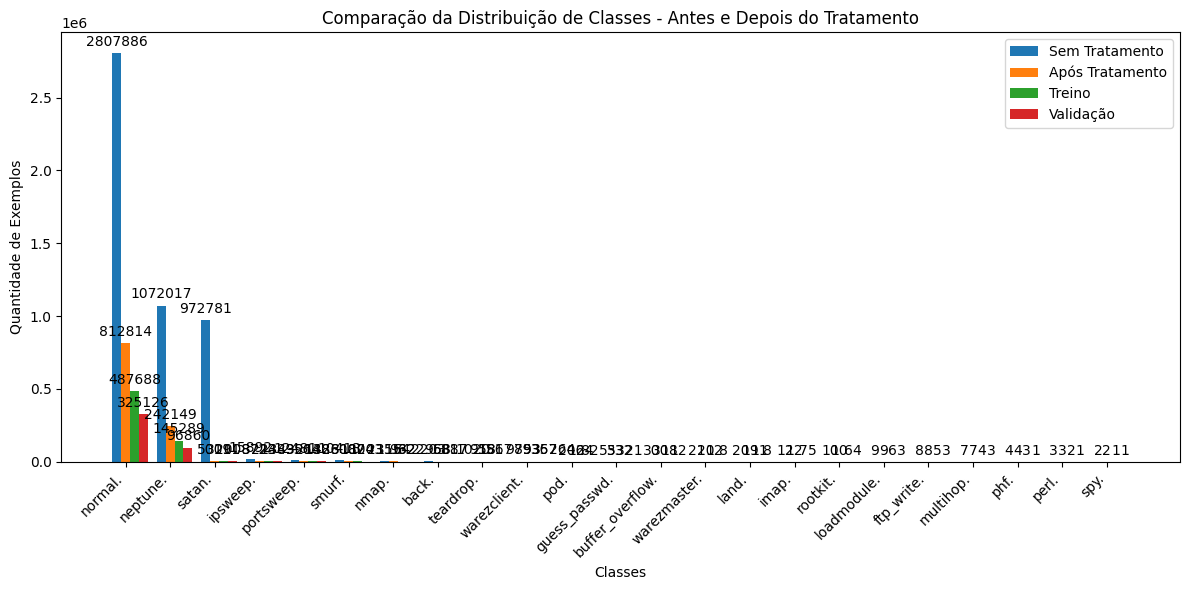

In [ ]:
# prompt: faça um grafico comparando as classes antes e depois do tratamento,  de uma maneira que de pra visualizar a diminuição de dados

import matplotlib.pyplot as plt

# Criar o gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(12, 6))

width = 0.2  # Largura das barras

x = np.arange(len(df_comparacao['Classe']))

rects1 = ax.bar(x - width, df_comparacao['Sem tratamento'], width, label='Sem Tratamento')
rects2 = ax.bar(x, df_comparacao['Total'], width, label='Após Tratamento')
rects3 = ax.bar(x + width, df_comparacao['Treino'], width, label='Treino')
rects4 = ax.bar(x + 2*width, df_comparacao['Validacao'], width, label='Validação')


# Adicionar rótulos e título
ax.set_xlabel('Classes')
ax.set_ylabel('Quantidade de Exemplos')
ax.set_title('Comparação da Distribuição de Classes - Antes e Depois do Tratamento')
ax.set_xticks(x)
ax.set_xticklabels(df_comparacao['Classe_Original'], rotation=45, ha="right") # Usar os nomes originais das classes
ax.legend()

# Adicionar valores acima de cada barra
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)


fig.tight_layout()
plt.show()

# Treinamento do modelo
* ### XGBoost - Classificação
#### Gradient Boosting Decision Trees
Encadeamento de Arveres de decisões em que o resultado da arvere influencia nos pesos da proxima arvere.

## Parâmetros:

### Objetivo para multiclasse
- objective='multi:softmax' ou 'multi:softprob':

 - 'multi:softmax': Retorna a classe diretamente.
 - 'multi:softprob': Retorna probabilidades para cada classe (caso
  queira análises adicionais).

- num_class=23:
  - Corresponde ao número de classes no seu dataset.

### Principais
- learning_rate:
   - Taxa de aprendizado. Pode começar com 0.1. Use menor (0.01) se aumentar o número de estimadores (n_estimators).
- n_estimators:

 - Quantidade de árvores. Um valor inicial é 200. Para mais precisão, aumente para 500, mas isso exigirá mais memória e tempo.

- max_depth:

 - Profundidade das árvores. Comece com 6. Ajuste para 4-8 dependendo do overfitting.
- subsample e colsample_bytree:

 - Controlam a fração de amostras e features usadas em cada árvore, respectivamente. Esses valores ajudam a prevenir overfitting.

### Desempenho
- tree_method='hist':

 - Método de construção das árvores otimizado para grandes datasets no Colab.
- reg_alpha e reg_lambda:

 - Regularização para controlar overfitting. Valores iniciais razoáveis são 0.1 e 1.

In [ ]:
# Defina os melhores parâmetros encontrados (sem GridSearchCV)
best_params = {
    'n_neighbors': 3,  # Exemplo: número de vizinhos
    'weights': 'uniform',  # Exemplo: pesos dos vizinhos
    'algorithm': 'auto',  # Exemplo: algoritmo para calcular vizinhos
    'leaf_size': 30, # Exemplo: tamanho da folha
    'p': 2,  # Exemplo: parâmetro de distância (2 para distância euclidiana)
    'weights':'distance'
}


# Inicialize o modelo KNN com os melhores parâmetros
knn_classifier = KNeighborsClassifier(**best_params, n_jobs=-1)

In [ ]:
model.fit(X_treino, y_treino)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=23, num_parallel_tree=None, ...)

In [ ]:
#y_pred = model.predict(X_treino)
#y_pred_proba = model.predict_proba(X_treino)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

In [ ]:
#matriz_confusao = confusion_matrix(y_treino, y_pred)

In [ ]:
''' # Calcular a acurácia do modelo
report = classification_report(y_treino, y_pred, output_dict=True)
accuracy = accuracy_score(y_treino, y_pred)
precisao = precision_score(y_treino, y_pred, average='weighted')
recall = recall_score(y_treino, y_pred, average='weighted')
f1 = f1_score(y_treino, y_pred, average='weighted') '''

In [ ]:
''' print("\nRelatório de Classificação:")
for label, metrics in report.items():
    if label != 'accuracy':  # Exclude overall accuracy
        print(f"\nMetrics for label '{label}':")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1-score: {metrics['f1-score']:.4f}")

# Calculate and print the overall accuracy percentage from the classification report
overall_accuracy = report['accuracy']
print(f"\nOverall Accuracy (from classification report): {overall_accuracy * 100:.2f}%")
# ... (rest of your existing code) '''


Relatório de Classificação:

Metrics for label '0':
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Metrics for label '1':
  Precision: 0.5000
  Recall: 1.0000
  F1-score: 0.6667

Metrics for label '2':
  Precision: 0.2083
  Recall: 1.0000
  F1-score: 0.3448

Metrics for label '3':
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Metrics for label '4':
  Precision: 0.7000
  Recall: 1.0000
  F1-score: 0.8235

Metrics for label '5':
  Precision: 0.9969
  Recall: 0.9996
  F1-score: 0.9982

Metrics for label '6':
  Precision: 0.7333
  Recall: 1.0000
  F1-score: 0.8462

Metrics for label '7':
  Precision: 0.6667
  Recall: 1.0000
  F1-score: 0.8000

Metrics for label '8':
  Precision: 0.4000
  Recall: 1.0000
  F1-score: 0.5714

Metrics for label '9':
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Metrics for label '10':
  Precision: 0.9811
  Recall: 1.0000
  F1-score: 0.9904

Metrics for label '11':
  Precision: 1.0000
  Recall: 0.9997
  F1-score: 0.9998

Metrics 

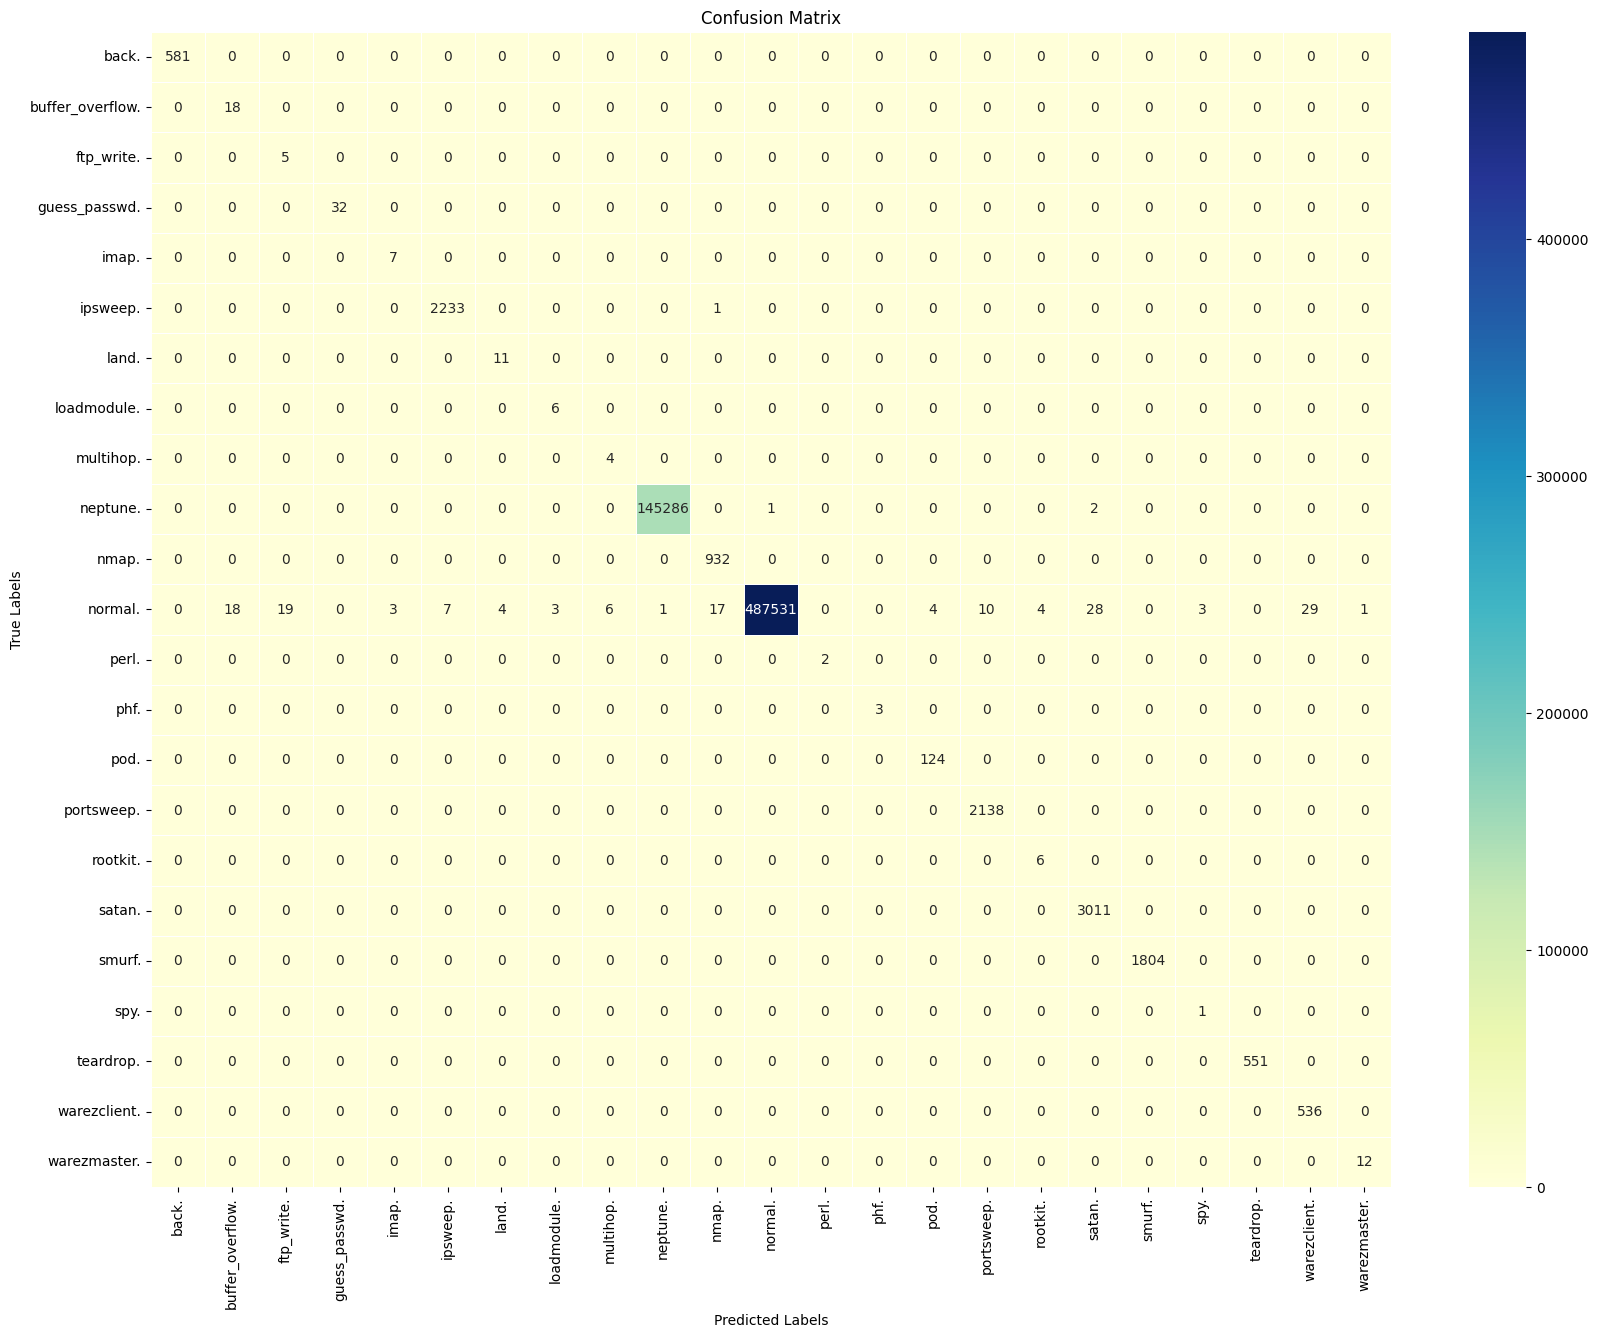

In [ ]:
''' from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ... (your existing code) ...

# Calculate the confusion matrix
# Plot the confusion matrix using seaborn
plt.figure(figsize=(20, 15))
sns.heatmap(matriz_confusao,  annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show() '''

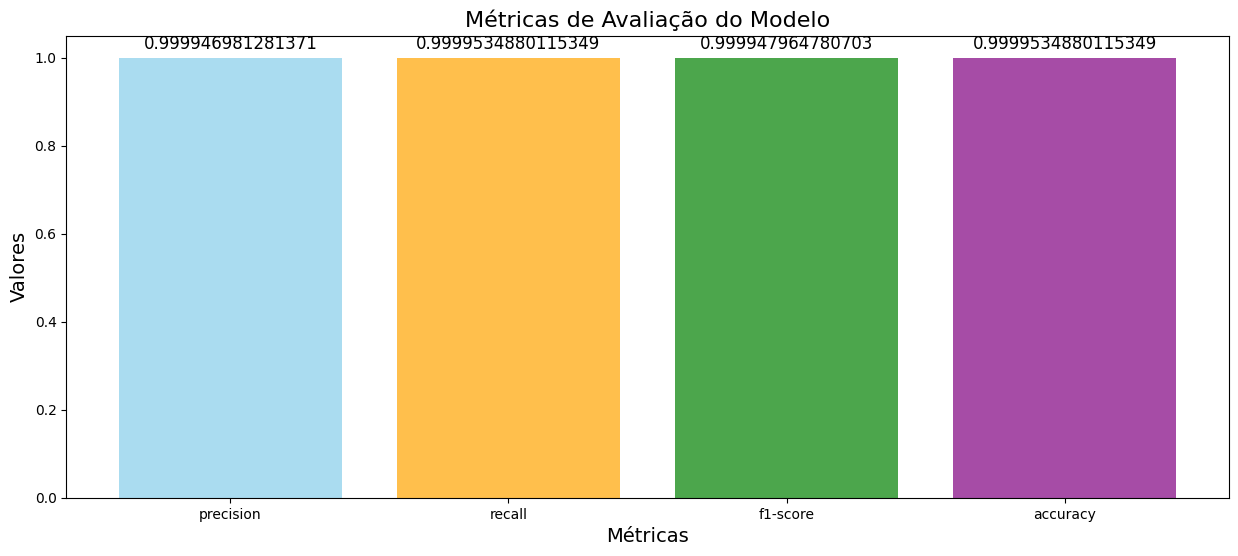

In [ ]:
''' import matplotlib.pyplot as plt
import numpy as np
from copy import copy

metrics = copy(report['weighted avg'])
metrics['accuracy'] = report["accuracy"]
metrics.pop('support')

# Nomes e valores das métricas
labels = list(metrics.keys())
values = list(metrics.values())

# Criar gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(labels, values, color=['skyblue', 'orange', 'green', 'purple'], alpha=0.7)
#plt.ylim(0, 1)  # Definir limite do eixo Y entre 0 e 1
plt.title("Métricas de Avaliação do Modelo", fontsize=16)
plt.ylabel("Valores", fontsize=14)
plt.xlabel("Métricas", fontsize=14)

# Adicionar valores no topo das barras
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v}", ha='center', fontsize=12)

plt.show() '''

<Figure size 1200x600 with 0 Axes>

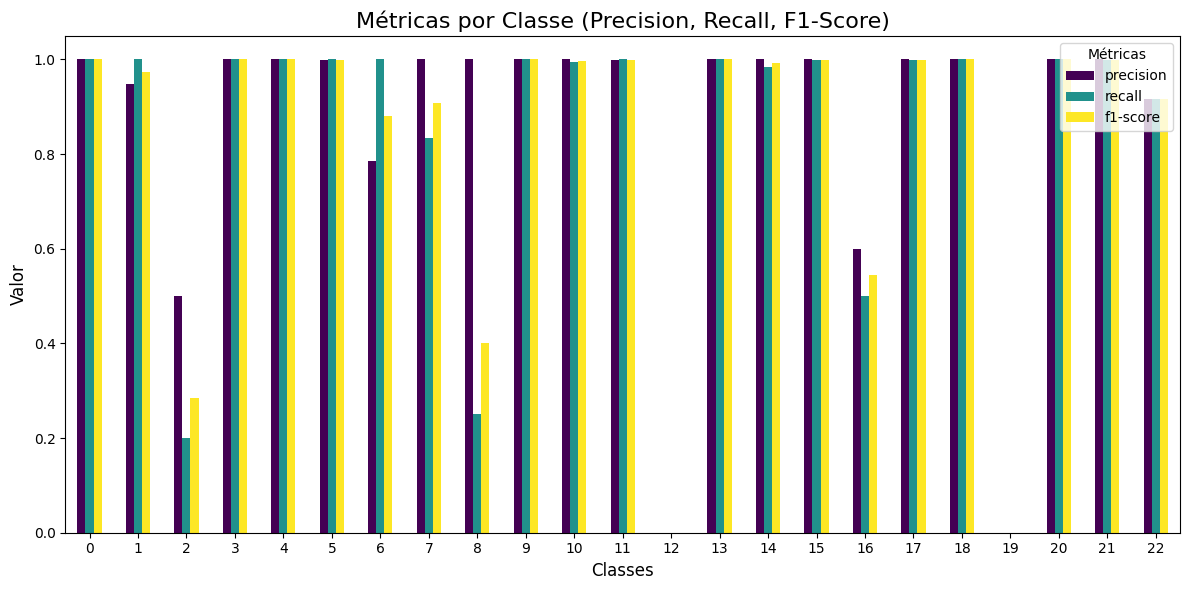

In [ ]:
''' import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report

# Exemplo: Gerar o classification_report (substitua pelo seu y_validacao e y_pred_v)
# report_v = classification_report(y_validacao, y_pred_v, output_dict=True)

# 1. Transformar o relatório em DataFrame
df_report = pd.DataFrame(report).T

# 2. Separar as métricas das classes e médias gerais
classes = df_report.iloc[:-3, :3]  # Todas as classes (exclui últimas linhas como 'accuracy')
medias = df_report.iloc[-2:, :3]  # 'macro avg' e 'weighted avg'

# 3. Gráfico 1: Métricas por Classe
plt.figure(figsize=(12, 6))
classes.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title("Métricas por Classe (Precision, Recall, F1-Score)", fontsize=16)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Valor", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Métricas", loc='upper right')
plt.tight_layout()
plt.show() '''

In [ ]:
y_pred_v = model.predict(X_validacao)
y_pred_proba_v = model.predict_proba(X_validacao)

In [ ]:
matriz_confusao_v = confusion_matrix(y_validacao, y_pred_v)

In [ ]:
len(y_validacao), len(y_pred_v)

(429997, 429997)

In [ ]:
# Calcular a acurácia do modelo
report_v = classification_report(y_validacao, y_pred_v, output_dict=True)
accuracy_v = report_v['accuracy']
precisao_v = report_v['weighted avg']['precision']
recall_v = report_v['weighted avg']['recall']
f1_v = report_v['weighted avg']['f1-score']

In [ ]:
print("\nRelatório de Classificação:")
for label, metrics in report_v.items():
    if label != 'accuracy':  # Exclude overall accuracy
        print(f"\nMetrics for label '{label}':")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1-score: {metrics['f1-score']:.4f}")

# Calculate and print the overall accuracy percentage from the classification report
overall_accuracy = report_v['accuracy']
print(f"\nOverall Accuracy (from classification report): {overall_accuracy * 100:.2f}%")
# ... (rest of your existing code)


Relatório de Classificação:

Metrics for label '0':
  Precision: 0.9974
  Recall: 1.0000
  F1-score: 0.9987

Metrics for label '1':
  Precision: 0.5000
  Recall: 0.9167
  F1-score: 0.6471

Metrics for label '2':
  Precision: 0.2143
  Recall: 1.0000
  F1-score: 0.3529

Metrics for label '3':
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Metrics for label '4':
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Metrics for label '5':
  Precision: 0.9886
  Recall: 0.9926
  F1-score: 0.9906

Metrics for label '6':
  Precision: 0.7273
  Recall: 1.0000
  F1-score: 0.8421

Metrics for label '7':
  Precision: 0.1818
  Recall: 0.6667
  F1-score: 0.2857

Metrics for label '8':
  Precision: 1.0000
  Recall: 0.3333
  F1-score: 0.5000

Metrics for label '9':
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Metrics for label '10':
  Precision: 0.9669
  Recall: 0.9855
  F1-score: 0.9761

Metrics for label '11':
  Precision: 0.9999
  Recall: 0.9996
  F1-score: 0.9998

Metrics 

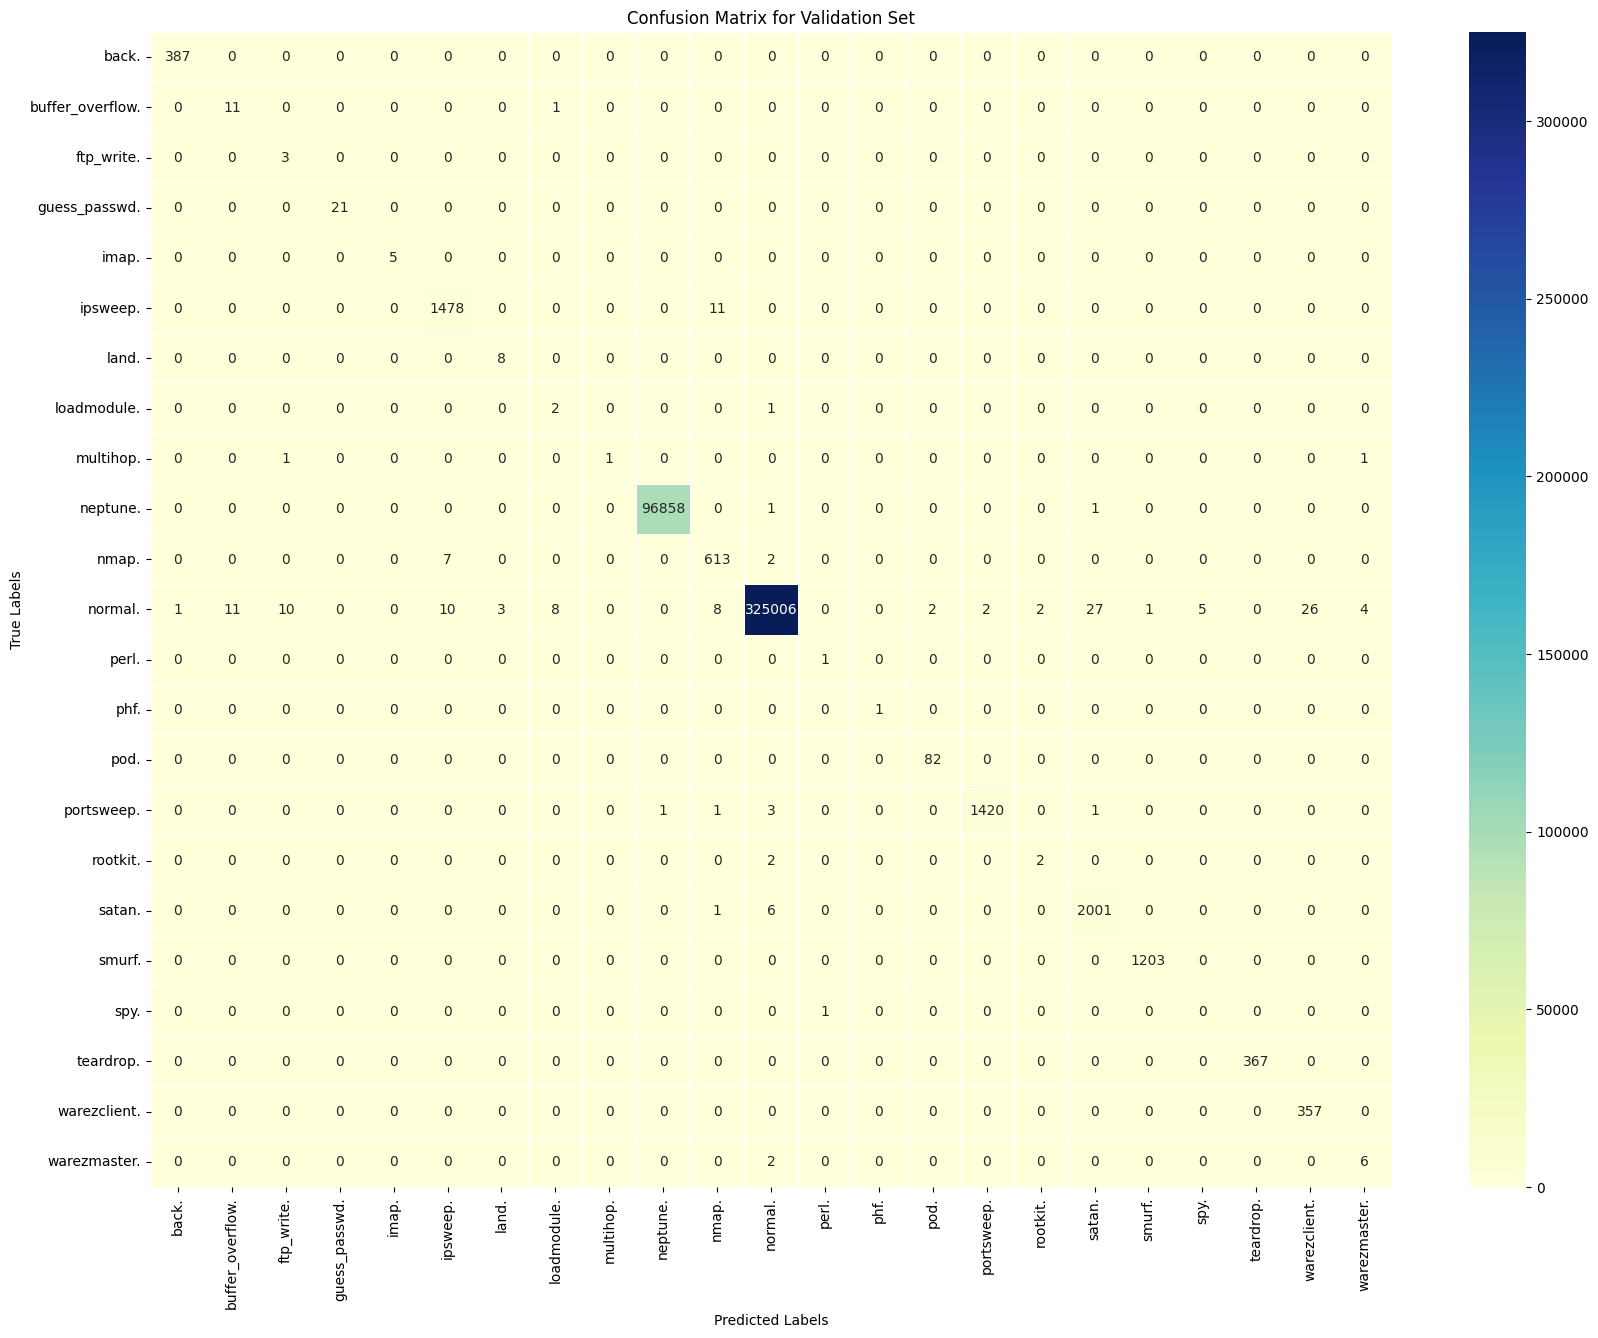

In [ ]:
# prompt: gere uma matriz de confusão para y_validacao e y_pred_v

# ... (your existing code) ...

# Calculate the confusion matrix for validation set
matriz_confusao_v = confusion_matrix(y_validacao, y_pred_v)

# Plot the confusion matrix for validation set using seaborn
plt.figure(figsize=(20, 15))
sns.heatmap(matriz_confusao_v, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Validation Set")
plt.show()

In [ ]:
arr = y_pred_v
# Contar as ocorrências de 9
ocorrencias_9 = np.count_nonzero(arr == 17)
ocorrencias_9, #0 #2008

(2030,)

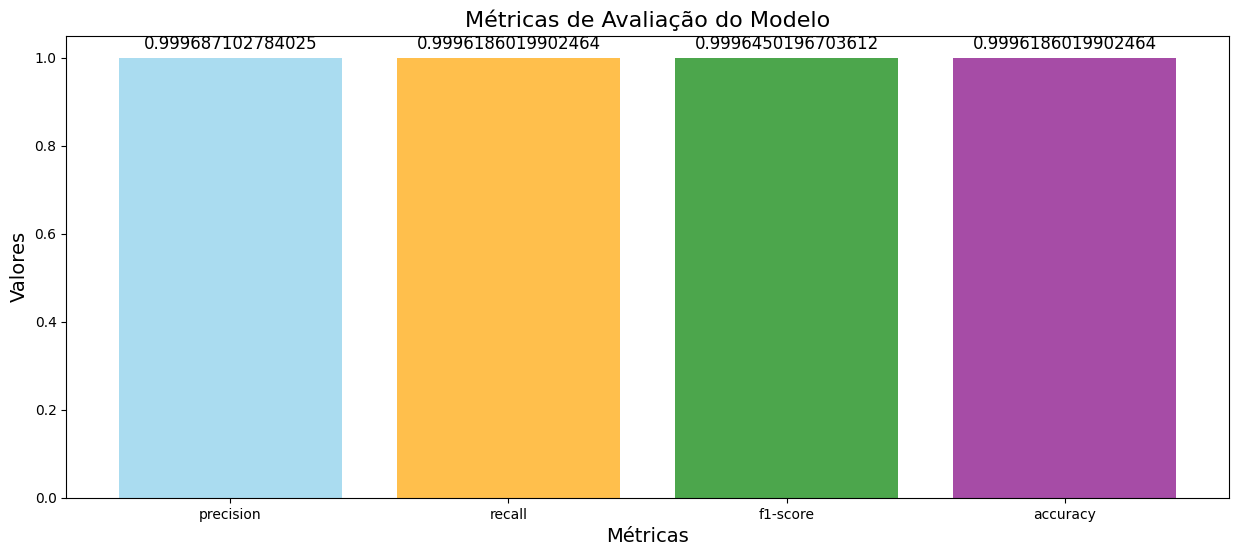

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from copy import copy

metrics = copy(report_v['weighted avg'])
metrics['accuracy'] = report_v["accuracy"]
metrics.pop('support')

# Nomes e valores das métricas
labels = list(metrics.keys())
values = list(metrics.values())

# Criar gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(labels, values, color=['skyblue', 'orange', 'green', 'purple'], alpha=0.7)
#plt.ylim(0, 1)  # Definir limite do eixo Y entre 0 e 1
plt.title("Métricas de Avaliação do Modelo", fontsize=16)
plt.ylabel("Valores", fontsize=14)
plt.xlabel("Métricas", fontsize=14)

# Adicionar valores no topo das barras
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v}", ha='center', fontsize=12)

plt.show()


<Figure size 1200x600 with 0 Axes>

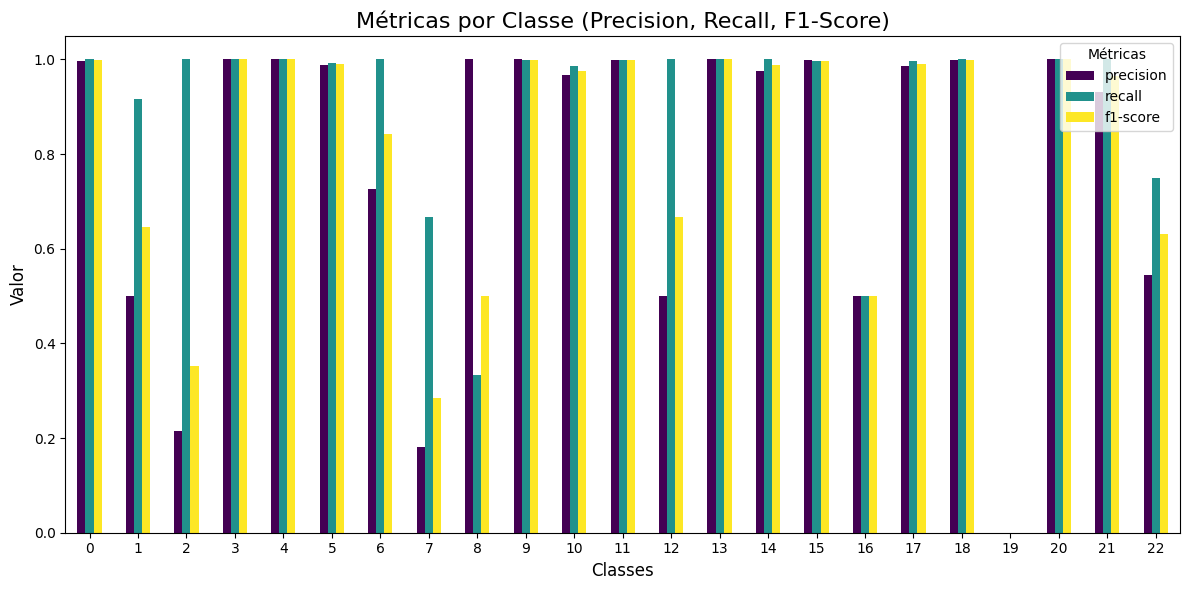

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report

# Exemplo: Gerar o classification_report (substitua pelo seu y_validacao e y_pred_v)
# report_v = classification_report(y_validacao, y_pred_v, output_dict=True)

# 1. Transformar o relatório em DataFrame
df_report = pd.DataFrame(report_v).T

# 2. Separar as métricas das classes e médias gerais
classes = df_report.iloc[:-3, :3]  # Todas as classes (exclui últimas linhas como 'accuracy')
medias = df_report.iloc[-2:, :3]  # 'macro avg' e 'weighted avg'

# 3. Gráfico 1: Métricas por Classe
plt.figure(figsize=(12, 6))
classes.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title("Métricas por Classe (Precision, Recall, F1-Score)", fontsize=16)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Valor", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Métricas", loc='upper right')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


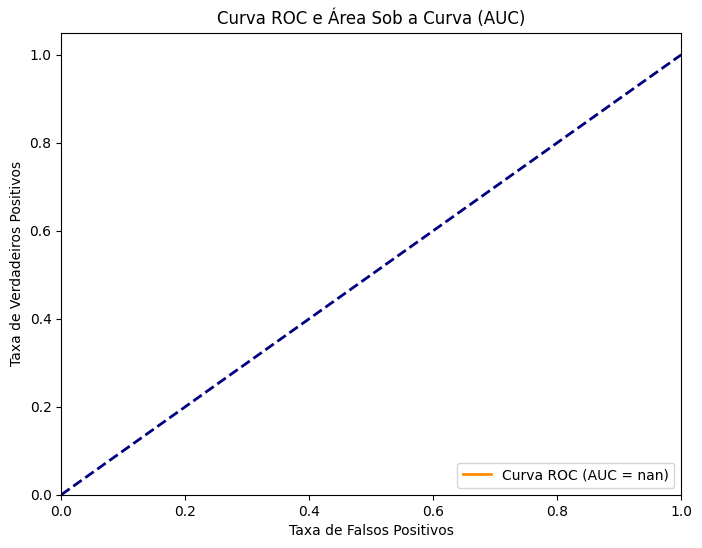

In [ ]:
from sklearn.metrics import roc_curve, auc
# Converter os rótulos de y_test para binário
y_test_binary = (y_validacao == 'normal.').astype(int)

# 10. Calcular a Curva ROC e AUC
y_pred_prob = y_pred_proba_v[:, 1]  # Probabilidades de classe positiva
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotar a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC e Área Sob a Curva (AUC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
df_comparacao